
# MMF1921/MIE377 - Backtesting Template

The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

# PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

# 1. Read input files

In [1]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd

In [2]:
alphas = []
llambdas = []
times = []
sharpes = []
turnovers = []

for alpha in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9, 0.95, 0.99]:
    for llambda in [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 10, 15, 20, 25, 40, 50, 75, 100]:

        adjClose = pd.read_csv("MIE377_AssetPrices1.csv", index_col=0)
        factorRet = pd.read_csv("MIE377_FactorReturns1.csv", index_col=0)

        adjClose.index = pd.to_datetime(adjClose.index)
        factorRet.index = pd.to_datetime(factorRet.index)

        # Initial budget to invest ($100,000)
        initialVal = 100000

        # Length of investment period (in months)
        investPeriod = 6

        # divide the factor returns by  100
        factorRet = factorRet/100

        #rf and factor returns
        riskFree = factorRet['RF']
        factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

        #Identify the tickers and the dates
        tickers = adjClose.columns
        dates   = factorRet.index

        # Calculate the stocks monthly excess returns
        # pct change and drop the first null observation
        returns = adjClose.pct_change(1).iloc[1:, :]


        returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
        # Align the price table to the asset and factor returns tables by discarding the first observation.
        adjClose = adjClose.iloc[1:,:]

        assert adjClose.index[0] == returns.index[0]
        assert adjClose.index[0] == factorRet.index[0]

        # Start of out-of-sample test period
        testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

        #End of the first investment period
        testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

        # End of calibration period
        calEnd = testStart -  pd.offsets.DateOffset(days = 1)

        # Total number of investment periods
        NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

        # Number of assets
        n  = len(tickers)

        # Preallocate space for the portfolio weights (x0 will be used to calculate
        # the turnover rate)
        x  = np.zeros([n, NoPeriods])
        x0 = np.zeros([n, NoPeriods])

        # Preallocate space for the portfolio per period value and turnover
        currentVal = np.zeros([NoPeriods, 1])
        turnover   = np.zeros([NoPeriods, 1])

        #Initiate counter for the number of observations per investment period
        toDay = 0

        # Measure runtime: start the clock
        start_time = time.time()

        # Empty list to measure the value of the portfolio over the period
        portfValue = []

        for t in range(NoPeriods):
            # Subset the returns and factor returns corresponding to the current calibration period.
            periodReturns = returns[returns.index <= calEnd]
            periodFactRet = factorRet[factorRet.index <= calEnd]

            current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
            currentPrices = adjClose[current_price_idx]

            # Subset the prices corresponding to the current out-of-sample test period.
            periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
            periodPrices = adjClose[periodPrices_idx]

            assert len(periodPrices) == investPeriod
            assert len(currentPrices) == 1
            # Set the initial value of the portfolio or update the portfolio value
            if t == 0:
                currentVal[0] = initialVal
            else:
                currentVal[t] = currentPrices @  NoShares.values.T
                #Store the current asset weights (before optimization takes place)
                x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

            #----------------------------------------------------------------------
            # Portfolio optimization
            # You must write code your own algorithmic trading function
            #----------------------------------------------------------------------
            x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], alpha, llambda)

            #Calculate the turnover rate
            if t > 0:
                turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

            # Number of shares your portfolio holds per stock
            NoShares = x[:,t]*currentVal[t]/currentPrices

            # Update counter for the number of observations per investment period
            fromDay = toDay
            toDay   = toDay + len(periodPrices)

            # Weekly portfolio value during the out-of-sample window
            portfValue.append(periodPrices@ NoShares.values.T)

            # Update your calibration and out-of-sample test periods
            testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
            testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
            calEnd    = testStart - pd.offsets.DateOffset(days=1)

        portfValue = pd.concat(portfValue, axis = 0)
        end_time = time.time()

        #--------------------------------------------------------------------------
        # 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
        #-----------------------------------------------------------------------
        # Calculate the observed portfolio returns
        portfRets = portfValue.pct_change(1).iloc[1:,:]

        # Calculate the portfolio excess returns
        portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

        # Calculate the portfolio Sharpe ratio
        SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

        # Calculate the average turnover rate
        avgTurnover = np.mean(turnover[1:])

        #Print Sharpe ratio and Avg. turnover to the console
        print('alpha:', alpha)
        print('lambda:', llambda)
        print("Elasped time is "+ str(end_time - start_time) + ' seconds')
        print('Sharpe ratio: ', str(SR[0]))
        print('Avg. turnover: ', str(avgTurnover))
        print('\n')

        alphas.append(alpha)
        llambdas.append(llambda)
        times.append(end_time - start_time)
        sharpes.append(SR[0])
        turnovers.append(avgTurnover)

alpha: 0.01
lambda: 0
Elasped time is 0.9462766647338867 seconds
Sharpe ratio:  0.5436098670508888
Avg. turnover:  0.18239985341673023


alpha: 0.01
lambda: 0.05
Elasped time is 0.7077457904815674 seconds
Sharpe ratio:  0.5443166859116123
Avg. turnover:  0.16776543858494447


alpha: 0.01
lambda: 0.1
Elasped time is 0.8629984855651855 seconds
Sharpe ratio:  0.5444545295232046
Avg. turnover:  0.1618948764713833


alpha: 0.01
lambda: 0.2
Elasped time is 0.717170238494873 seconds
Sharpe ratio:  0.5417933846623165
Avg. turnover:  0.1749783037930655


alpha: 0.01
lambda: 0.3
Elasped time is 0.9923422336578369 seconds
Sharpe ratio:  0.5341363892697722
Avg. turnover:  0.21427474281376532


alpha: 0.01
lambda: 0.4
Elasped time is 0.7461037635803223 seconds
Sharpe ratio:  0.519950369667787
Avg. turnover:  0.2702168817485037


alpha: 0.01
lambda: 0.5
Elasped time is 0.8447203636169434 seconds
Sharpe ratio:  0.49878504714182753
Avg. turnover:  0.35017612522200225


alpha: 0.01
lambda: 1
Elasped ti

In [3]:
df = pd.DataFrame({'alpha': alphas, 'lambda': llambdas,
                   'Time': times, 'Sharpe Ratio': sharpes, 'Turnover': turnovers})
df

,alpha,lambda,Time,Sharpe Ratio,Turnover
0,0.01,0.00,0.946277,0.543610,0.182400
1,0.01,0.05,0.707746,0.544317,0.167765
2,0.01,0.10,0.862998,0.544455,0.161895
3,0.01,0.20,0.717170,0.541793,0.174978
4,0.01,0.30,0.992342,0.534136,0.214275
...,...,...,...,...,...
195,0.99,25.00,1.108629,0.036612,1.070216
196,0.99,40.00,1.021154,0.017073,1.286439
197,0.99,50.00,1.635069,0.009091,1.320728
198,0.99,75.00,1.877802,-0.007002,1.393378


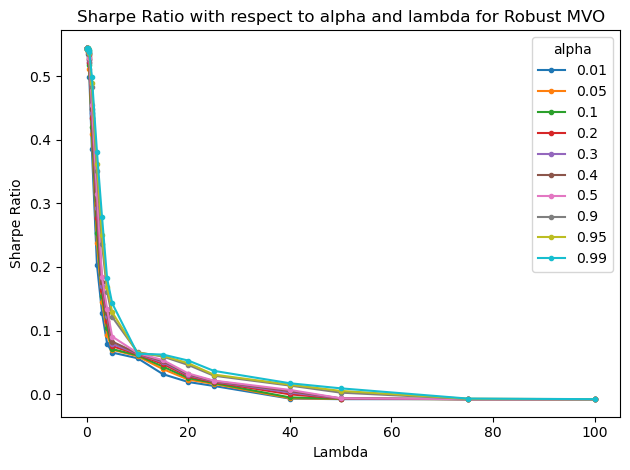

In [4]:
fig, ax1 = plt.subplots()
plt.title('Sharpe Ratio with respect to alpha and lambda for Robust MVO')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Sharpe Ratio')

for a in sorted(list(set(alphas))):
    sub_df = df[df['alpha'] == a]
    ax1.plot(sub_df['lambda'].values, sub_df['Sharpe Ratio'].values, label=str(a), marker='.')

ax1.legend(title='alpha')
plt.tight_layout()
plt.show()

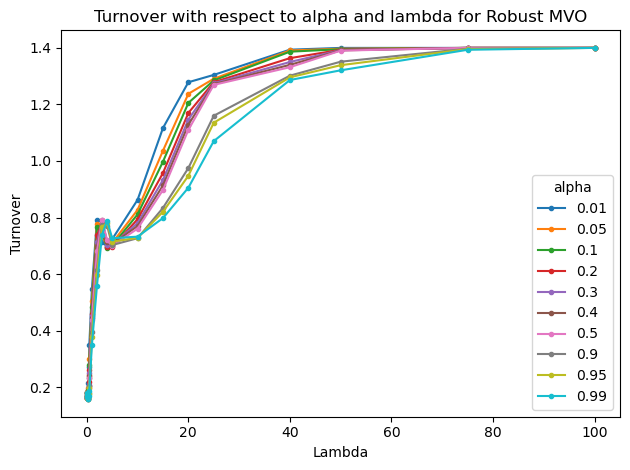

In [5]:
fig, ax1 = plt.subplots()
plt.title('Turnover with respect to alpha and lambda for Robust MVO')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Turnover')

for a in sorted(list(set(alphas))):
    sub_df = df[df['alpha'] == a]
    ax1.plot(sub_df['lambda'].values, sub_df['Turnover'].values, label=str(a), marker='.')

ax1.legend(title='alpha')
plt.tight_layout()
plt.show()

In [6]:
import seaborn as sns

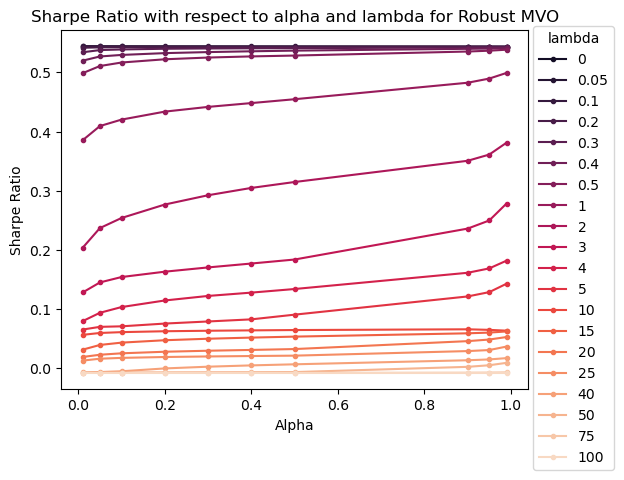

In [7]:
fig, ax1 = plt.subplots()
plt.title('Sharpe Ratio with respect to alpha and lambda for Robust MVO')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Sharpe Ratio')

clrs = sns.color_palette('rocket', n_colors=20)

i = 0
for l in sorted(list(set(llambdas))):
    sub_df = df[df['lambda'] == l]
    ax1.plot(sub_df['alpha'].values, sub_df['Sharpe Ratio'].values, label=str(l), marker='.', color=clrs[i])
    i += 1

ax1.legend(title='lambda', bbox_to_anchor=(1.2, 1.03))
plt.tight_layout()
plt.show()

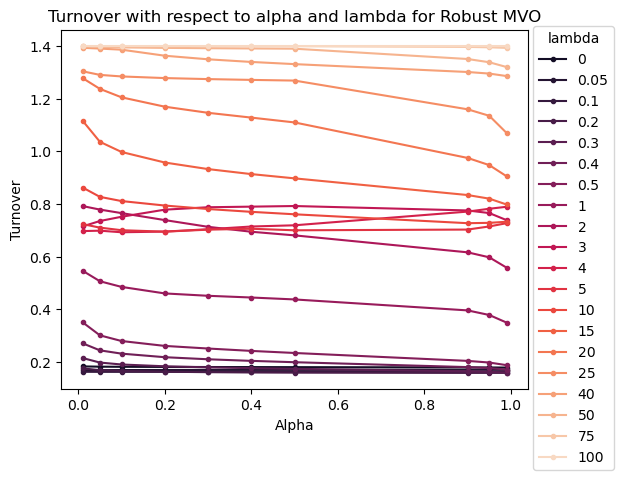

In [8]:
fig, ax1 = plt.subplots()
plt.title('Turnover with respect to alpha and lambda for Robust MVO')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Turnover')

clrs = sns.color_palette('rocket', n_colors=20)

i = 0
for l in sorted(list(set(llambdas))):
    sub_df = df[df['lambda'] == l]
    ax1.plot(sub_df['alpha'].values, sub_df['Turnover'].values, label=str(l), marker='.', color=clrs[i])
    i += 1

ax1.legend(title='lambda', bbox_to_anchor=(1.2, 1.03))
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

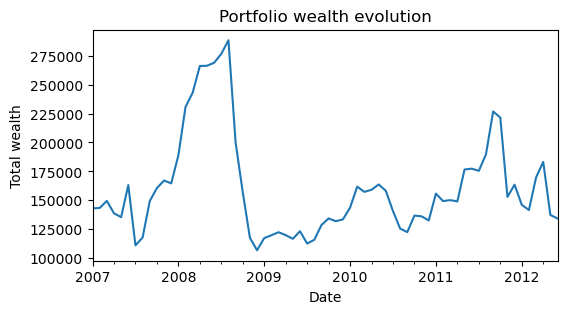

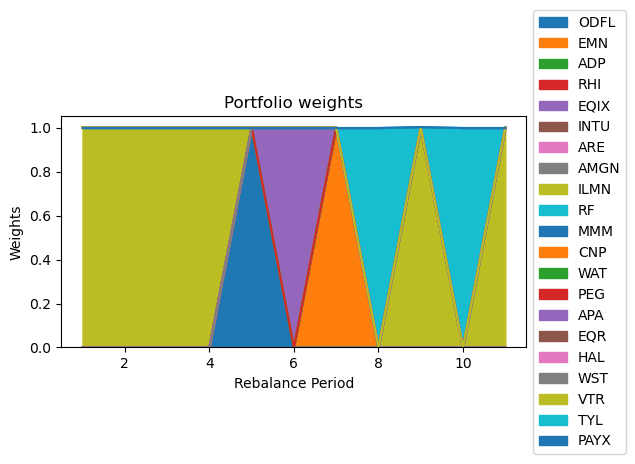

In [9]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%